# Example 1: A simple p-n junction

First, we import deltapv and necessary libraries. Notably, we use JAX's version of NumPy, which is purely functional and presents immutable arrays.

In [1]:
import deltapv as dpv
from jax import numpy as jnp, value_and_grad
from jax.experimental import optimizers
import matplotlib.pyplot as plt

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
___________________    __
______ \ __  __ \_ |  / /
_  __  /__  /_/ /_ | / / 
/ /_/ / _  ____/__ |/ /  
\__,_/  /_/     _____/   
                         


deltapv has a streamlined interface which allows defining a cell design with several lines of code. First, we must define the material that makes up the cell, which for the purpose of the example is a homojunction. The parameters have default values, so recombination parameters are not supplied here. Moreover, the units required are as follows:

eps : unitless

Chi , Eg , Et : eV

Nc , Nv , Ndop : cm^(-3)

mn , mp : cm^2 / V / s

tn , tp : s

A : cm^(-1) eV^(-1/2)

In [2]:
material = dpv.create_material(Chi=3.9,
                                Eg=1.5,
                                eps=9.4,
                                Nc=8e17,
                                Nv=1.8e19,
                                mn=100,
                                mp=100,
                                Et=0,
                                tn=1e-8,
                                tp=1e-8,
                                A=2e4)

We are ready to define the cell. The recombination velocities, in the format (Snl, Snr, Spl, Spr), are in units cm/s. We have equal donor and acceptor densities on either side of the pn junction, which has two layers of equal thickness 1e-4 cm. We simply use a uniform grid of 500 points for this example; where custom grids are required, the argument "grid" can be used to pass one.

In [3]:
des = dpv.make_design(n_points=500, Ls=[1e-4, 1e-4], mats=material, Ns=[1e17, -1e17], Snl=1e7, Snr=0, Spl=0, Spr=1e7)

While a PVDesign object contains all information about the cell, it does not contain light source information. In order to specify a custom light source, we must create a LightSource object with the incident_light() function. This defaults to returning the spectrum of one sun, but the spectrum can be specified with the kind ("sun", "white", "monochromatic", "user") and the wavelengths, Lambda, and corresponding power, P_in, respectively. However, the simulator defaults to using the solar spectrum when no light source object is passed, so it is unnecessary here.

Now we are ready to run the simulation, which solves for the equilibrium system, then the out-of-equilibrium case with illumination and bias up to the point when the current drops below zero.

In [4]:
results = dpv.simulate(des)

Solving equilibrium...
    iteration   1    |p| = 4.35e+01    |F| = 8.29e+00
    iteration   2    |p| = 3.77e+01    |F| = 5.70e+00
    iteration   3    |p| = 2.92e+01    |F| = 4.51e+00
    iteration   4    |p| = 1.95e+01    |F| = 3.71e+00
    iteration   5    |p| = 1.28e+01    |F| = 2.93e+00
    iteration   6    |p| = 1.34e+01    |F| = 2.20e+00
    iteration   7    |p| = 1.16e+01    |F| = 1.55e+00
    iteration   8    |p| = 8.94e+00    |F| = 1.06e+00
    iteration   9    |p| = 6.17e+00    |F| = 7.65e-01
    iteration  10    |p| = 3.72e+00    |F| = 4.73e-01
    iteration  11    |p| = 1.72e+00    |F| = 2.29e-01
    iteration  12    |p| = 3.43e-01    |F| = 5.58e-02
    iteration  13    |p| = 6.32e-12    |F| = 4.65e-14
Solving for 0.00 V (Step   0)...
    iteration   1    |p| = 1.00e+00    |F| = 4.65e+01
    iteration   2    |p| = 1.00e+00    |F| = 1.71e+01
    iteration   3    |p| = 1.02e+00    |F| = 2.59e+00
    iteration   4    |p| = 1.63e+00    |F| = 2.76e-01
    iteration   5    |p| =

The results returned are in the form of a dictionary with keys {"cell", "eq", "Voc", "mpp", "eff", "iv"}. "cell" refers to the initialized PVCell object which contains the generation density G from the optical model. "eq" and "Voc" are the solution potentials in the form of a named tuple for the equilibrium and Voc cases. "mpp" is the maximal power through the cell, and "iv" is a tuple of  voltages and currents describing the IV curve. deltapv provides several plotting functions, all of which can save the plot with keyword argument "filename".

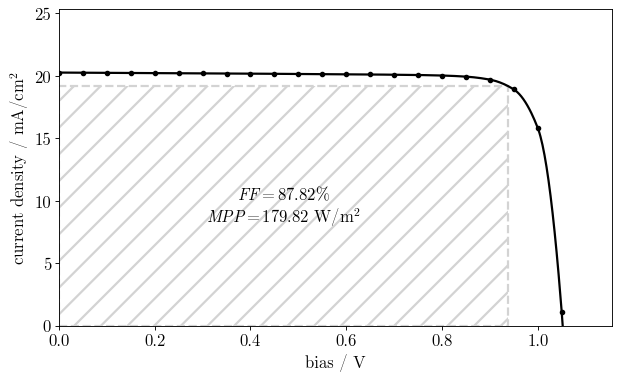

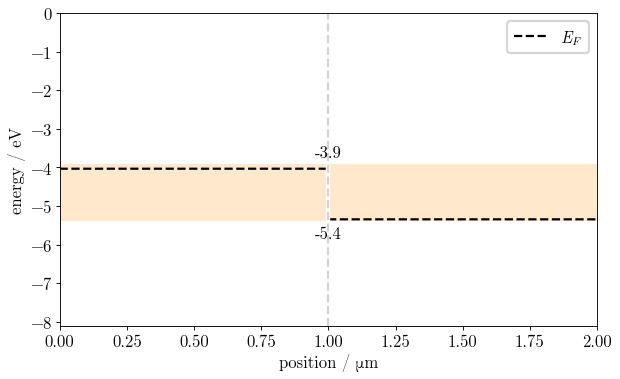

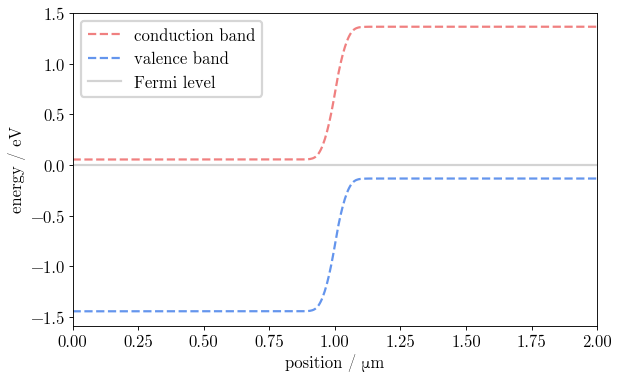

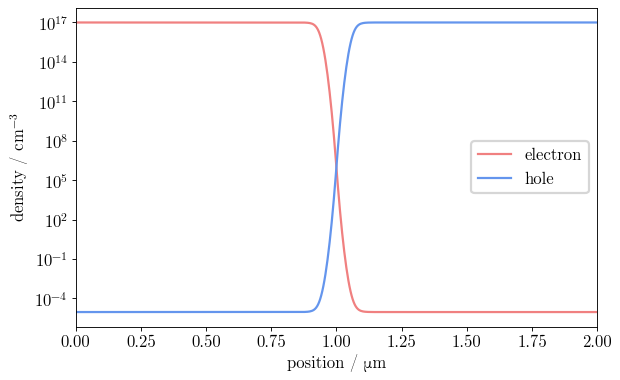

In [5]:
dpv.plot_iv_curve(*results["iv"])
dpv.plot_bars(des)
dpv.plot_band_diagram(des, results["eq"], eq=True)
dpv.plot_charge(des, results["eq"])

# Example 2: Optimizing a perovskite solar cell

First we define the fixed parameters below, together with the lower and upper bounds for all the optimized variables. The perovskite material is held fixed in this example, so we define it beforehand.

In [8]:
L_ETM = 5e-5
L_Perov = 1.1e-4
L_HTM = 5e-5
N = 500
A = 2e4
tau = 1e-6
S = 1e7
Eg_P = 1.5
Chi_P = 3.9
eps_P = 10
Nc_P = 3.9e18
Nv_P = 2.7e18
mn_P = 2
mp_P = 2
Br_P = 2.3e-9

Perov = dpv.create_material(Eg=Eg_P, Chi=Chi_P, eps=eps_P,
                            Nc=Nc_P, Nv=Nv_P, mn=mn_P,
                            mp=mp_P, tn=tau, tp=tau,
                            Br=Br_P, A=A)

vl = jnp.array([1, 1, 1, 17, 17, 0, 0, 1, 1, 1, 17, 17, 0, 0, 17, 17], dtype=jnp.float64)
vu = jnp.array([5, 5, 20, 20, 20, 3, 3, 5, 5, 20, 20, 20, 3, 3, 20, 20], dtype=jnp.float64)

Next, we define a function to compute a quadratic exterior penalty for a candidate design. Aside from the box constraints, we also penalize for violating 5 generally nonlinear constraints.

In [9]:
def penalty(params, sigma=1e4):
    Eg_ETM = params[0]
    Chi_ETM = params[1]
    Nc_ETM = 10**params[3]
    Nv_ETM = 10**params[4]
    Eg_HTM = params[7]
    Chi_HTM = params[8]
    Nc_HTM = 10**params[10]
    Nv_HTM = 10**params[11]
    Nd_ETM = 10**params[14]
    Na_HTM = 10**params[15]

    PhiM0 = dpv.physics.flatband_wf(Nc_ETM, Nv_ETM, Eg_ETM, Chi_ETM, Nd_ETM)
    PhiML = dpv.physics.flatband_wf(Nc_HTM, Nv_HTM, Eg_HTM, Chi_HTM, -Na_HTM)

    g = jnp.array([Chi_ETM - PhiM0, Chi_HTM - Chi_P, PhiML - Chi_HTM - Eg_HTM,
                  Chi_HTM + Eg_HTM - Chi_P - Eg_P, Chi_P - Chi_ETM])
    
    upper = jnp.clip(params - vu, a_min=0)
    lower = jnp.clip(vl - params, a_min=0)
    cons = jnp.clip(g, a_min=0)
    pen = sigma * (jnp.sum(upper**2) + jnp.sum(lower**2) + jnp.sum(cons**2))

    return pen

Finally, we specify how to convert a parameter vector into a PVDesign, and the objective function f makes use of this to return the penalized negative efficiency given a parameter vector.

JAX's value_and_grad function is then used to differentiate f in an end-to-end manner, returning a function, df, which returns both the efficiency and its gradient with respect to the parameter vector.

In [15]:
def x2des(params, perov=Perov):
    Eg_ETM = params[0]
    Chi_ETM = params[1]
    eps_ETM = params[2]
    Nc_ETM = 10**params[3]
    Nv_ETM = 10**params[4]
    mn_ETM = 10**params[5]
    mp_ETM = 10**params[6]
    Eg_HTM = params[7]
    Chi_HTM = params[8]
    eps_HTM = params[9]
    Nc_HTM = 10**params[10]
    Nv_HTM = 10**params[11]
    mn_HTM = 10**params[12]
    mp_HTM = 10**params[13]
    Nd_ETM = 10**params[14]
    Na_HTM = 10**params[15]

    ETM = dpv.create_material(Eg=Eg_ETM,
                            Chi=Chi_ETM,
                            eps=eps_ETM,
                            Nc=Nc_ETM,
                            Nv=Nv_ETM,
                            mn=mn_ETM,
                            mp=mp_ETM,
                            tn=tau,
                            tp=tau,
                            A=A)
    HTM = dpv.create_material(Eg=Eg_HTM,
                            Chi=Chi_HTM,
                            eps=eps_HTM,
                            Nc=Nc_HTM,
                            Nv=Nv_HTM,
                            mn=mn_HTM,
                            mp=mp_HTM,
                            tn=tau,
                            tp=tau,
                            A=A)

    des = dpv.make_design(n_points=N, Ls=[L_ETM, L_Perov, L_HTM], mats=[ETM, perov, HTM], Ns=[Nd_ETM, 0, -Na_HTM], Snl=S, Snr=S, Spl=S, Spr=S)

    return des


def f(params):
    des = x2des(params)
    results = dpv.simulate(des, verbose=False)
    eff = results["eff"] * 100
    pen = penalty(params)
    return -eff + pen

df = value_and_grad(f)

We are now ready to begin the optimization process! For illustration purposes, we only do 10 gradient descent steps.

In [16]:
x0 = jnp.array([1.661788237392516, 4.698293002285373, 19.6342803183675, 18.83471869026531, 19.54569869328745, 0.7252792557586427, 1.6231392299175988, 2.5268524699070234, 2.51936429069554, 6.933634938056497, 19.41835918276137, 18.271793488422656, 0.46319949214386513, 0.2058139980642224, 18.63975340175838, 17.643726318153238])

results = dpv.util.adam(df, x0, lr=0.01, b1=0.1, b2=0.1, steps=10)
growth = results["f"]
final = results["x"][-1]

Starting Adam with:
    x0    = +1.66e+00, +4.70e+00, +1.96e+01, +1.88e+01, +1.95e+01, +7.25e-01, +1.62e+00, +2.53e+00, +2.52e+00, +6.93e+00, +1.94e+01, +1.83e+01, +4.63e-01, +2.06e-01, +1.86e+01, +1.76e+01
    lr    = 1.00e-02
    b1    = 1.00e-01
    b2    = 1.00e-01
    steps =  10
    tol   = 0.00e+00
    gtol  = 0.00e+00
iteration   1
    f(x)  = -6.49e+00
    x     = +1.66e+00, +4.70e+00, +1.96e+01, +1.88e+01, +1.95e+01, +7.25e-01, +1.62e+00, +2.53e+00, +2.52e+00, +6.93e+00, +1.94e+01, +1.83e+01, +4.63e-01, +2.06e-01, +1.86e+01, +1.76e+01
    df/dx = -1.04e+00, +1.33e+01, +1.71e-03, +7.93e-01, +3.46e-05, -2.42e-03, -1.40e-02, -1.13e+01, -1.14e+01, +2.86e-03, +1.18e-07, +6.76e-01, -5.44e-05, -1.60e-04, -7.75e-01, -6.35e-01
iteration   2
    f(x)  = -6.88e+00
    x     = +1.67e+00, +4.69e+00, +1.96e+01, +1.88e+01, +1.95e+01, +7.35e-01, +1.63e+00, +2.54e+00, +2.53e+00, +6.92e+00, +1.94e+01, +1.83e+01, +4.73e-01, +2.16e-01, +1.86e+01, +1.77e+01
    df/dx = -1.14e+00, +1.38e+01, +1.50

We compare the initial and final designs by plotting the energy levels. The efficiency is also seen to grow steadily over the 10 iterations from 6.5% to 9%.

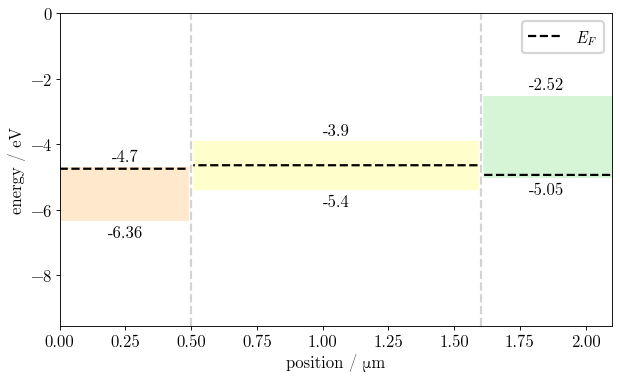

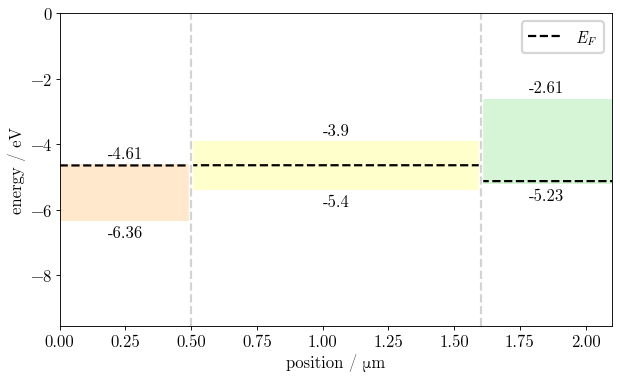

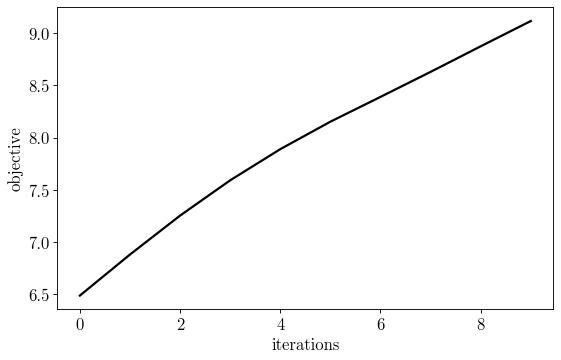

In [18]:
dpv.plot_bars(x2des(x0))
dpv.plot_bars(x2des(final))

plt.plot(-growth, color="black")
plt.xlabel("iterations")
plt.ylabel("objective")
plt.show()

# Example 3: Using empirical $IV$ curve for material discovery

Here, we extend the use of gradients to "discover" unknown parameters using an experimentally acquired $IV$ curve. Now suppose we have a material whose $E_g$ and $\mu_p$ are unknown, and we have a "target" $IV$ curve from empirical measurements, $J^*$ (which will be generated via simulation here for the sake of the example). We use simulations to match the candidate and empirical $IV$ curves, specifically to minimize the radial difference between the two curves integrated in polar coordinates. This objective is conveniently provided by deltapv.

First, we create the material that we will investigate:

In [19]:
material = dpv.create_material(Eg=1.0,
                               Chi=3.0,
                               eps=10.0,
                               Nc=1e18,
                               Nv=1e18,
                               mn=130.0,
                               mp=160.0,
                               A=2e4)

Now we define a helper function that returns the $IV$ curve for a homojunction made of the material, but with guesses for $E_g$ and $\mu_p$ specified by the arguments. We also compute the "empirical" $IV$ curve, which we will use to define the objective function.

In [21]:
def get_iv(Eg, mp):
    candidate = dpv.objects.update(material, Eg=Eg, mp=mp)
    des = dpv.make_design(n_points=500,
                          Ls=[1e-4, 1e-4],
                          mats=candidate,
                          Ns=[1e17, -1e17],
                          Snl=1e7,
                          Snr=0,
                          Spl=0,
                          Spr=1e7)
    results = dpv.simulate(des, verbose=False)
    return results["iv"][1]

J0 = get_iv(Eg=1.0, mp=160.0)

Now we define the objective function. Since $\mu_p$ has values in a large range, we transform the optimization variable to the log of it. The function simply computes the $IV$ curve with the proposed parameters, and uses the polar residual function provided by deltapv to compute the objective. With the help of JAX, we can immediately get the gradient of the function as well.

In [23]:
def f(x):
    mp = 10**x[0]
    Eg = x[1]
    J = get_iv(Eg=Eg, mp=mp)
    res = dpv.util.dpol(J, J0)
    return res

df = value_and_grad(f)

What remains is to perform the optimization using Adagrad! We will perform 50 gradient steps, which takes no more than a few minutes.

In [30]:
result = dpv.util.adagrad(df, [2.0, 1.2], lr=0.1, steps=50)

Starting Adagrad with:
    x0       = +2.00e+00, +1.20e+00
    lr       = 1.00e-01
    momentum = 9.00e-01
    steps    =  50
    tol      = 0.00e+00
    gtol     = 0.00e+00
iteration   1
    f(x)  = 1.42e+00
    x     = +2.00e+00, +1.20e+00
    df/dx = -7.60e-01, +1.60e+01
iteration   2
    f(x)  = 1.28e+00
    x     = +2.01e+00, +1.19e+00
    df/dx = -6.91e-01, +1.05e+01
iteration   3
    f(x)  = 1.12e+00
    x     = +2.03e+00, +1.18e+00
    df/dx = -6.24e-01, +1.15e+01
iteration   4
    f(x)  = 9.02e-01
    x     = +2.05e+00, +1.16e+00
    df/dx = -5.98e-01, +9.66e+00
iteration   5
    f(x)  = 6.76e-01
    x     = +2.07e+00, +1.14e+00
    df/dx = -4.51e-01, +6.56e+00
iteration   6
    f(x)  = 5.15e-01
    x     = +2.09e+00, +1.12e+00
    df/dx = -3.74e-01, +8.36e+00
iteration   7
    f(x)  = 3.30e-01
    x     = +2.11e+00, +1.09e+00
    df/dx = -2.93e-01, +5.29e+00
iteration   8
    f(x)  = 2.21e-01
    x     = +2.14e+00, +1.07e+00
    df/dx = -2.34e-01, +5.49e+00
iteration   9
    

Examining the objective, we see it going down quickly. The parameters also clearly approach the true values.

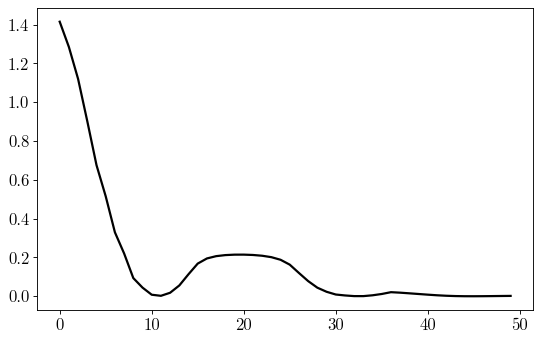

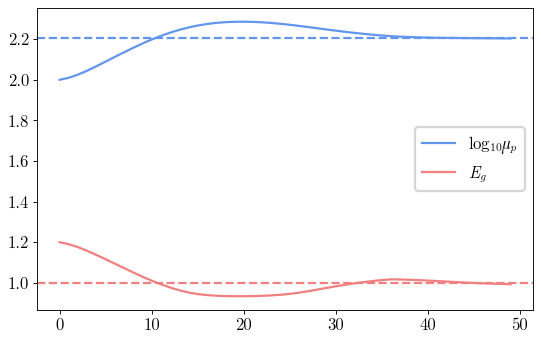

In [32]:
plt.plot(result["f"], color="black")
plt.show()

plt.plot(result["x"][:, 0], label="$\log_{10} \mu_p$", color="cornflowerblue")
plt.plot(result["x"][:, 1], label="$E_g$", color="lightcoral")
plt.axhline(jnp.log10(160), color="cornflowerblue", linestyle="--")
plt.axhline(1.0, color="lightcoral", linestyle="--")
plt.legend()
plt.show()